# Sentiment Analysis of Tweets and Depression Detection

## Problem Statement

"Finding if a person is depressed from their use of words on social media can definitely help in the cure! Sentimental Analysis can be very useful to find out depression and cure it before someone gets into serious trouble." - so, the goal will be to predict whether the person has the depression based in his/her tweets.

## Data

**link** to Kaggle: https://www.kaggle.com/gargmanas/sentimental-analysis-for-tweets

## Project content

1) Data Import

2) Data Preprocessing

3) Checking whether the data is imbalanced

4) Vectorizing the data with CountVectorizer and TfidfVectorizer

5) Building the SVM model

6) Function for single predictions

7) Conclusion

## Data import 

In [136]:
#importing all libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer #for lemmatization
from nltk.corpus import stopwords #english stopwords dataset
from nltk.tokenize import word_tokenize, regexp_tokenize #tokenization of the words
import regex as re #regular expressions

In [137]:
df = pd.read_csv("/Users/polyanaboss/Downloads/sentiment_tweets3.csv")

In [138]:
#looking at the first rows
df.head()

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [139]:
#number of rows and columns
df.shape

(10314, 3)

In [140]:
#dropping unnecessary index column
df.drop("Index", axis = 1, inplace = True)

In [141]:
#renaming the columns for simplicity
df.rename(columns = {"message to examine" : "text", "label (depression result)" : "depression"}, inplace = True)

## Data Preprocessing

The first thing that should be done is deletion of all mentions, links and hashtags from the data because it does not show any signs of depression.

In [142]:
import warnings
warnings.filterwarnings("ignore")
#removing links
for i in range(len(df)):
    df["text"][i] = re.sub(r"http\S+", "",  df["text"][i], flags=re.MULTILINE)

In [143]:
#removing mentions
for i in range(len(df)):
    df["text"][i] = re.sub(r"@\S+", "",  df["text"][i], flags=re.MULTILINE)

In [144]:
#removing hashtags
for i in range(len(df)):
    df["text"][i] = re.sub(r"#\S+", "",  df["text"][i], flags=re.MULTILINE)

In [145]:
#checking the result
df.head()

,text,depression
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga,0
2,-,0
3,Need to send 'em to my accountant tomorrow. O...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


One can notice that there can be the case like in the 3rd row in text column that there is no relevant information presented after all cleaning processes. Lets find out the total number of texts similar to this issue.

In [146]:
#total number of observations
c = 0
short = []
short_indices = []
for i in range(len(df)):
     if len(df['text'][i]) < 10:
        short.append(df['text'][i])
        short_indices.append(i)
        c += 1
               
c

102

In total, there are 102 tweets with the length less than 10 characters. 

In [147]:
#looking at the short tweets, there is no sence and need in them, we will drop them
short[:10]

['  -  ',
 ' ',
 'around. ',
 ' nothing ',
 ' thanks ',
 ' ',
 ' Nope. ',
 '  awww! ',
 'bed time ',
 ' it is. ']

In [148]:
#removing short tweets
df.drop(index = short_indices, axis = 0, inplace = True)

### Checking whether the data is imbalanced

One more problem can be connected with probable imbalance in the label distribution. We will figure it out via plots.

Text(0.5, 1.0, 'Ratio of depressed and happy people')

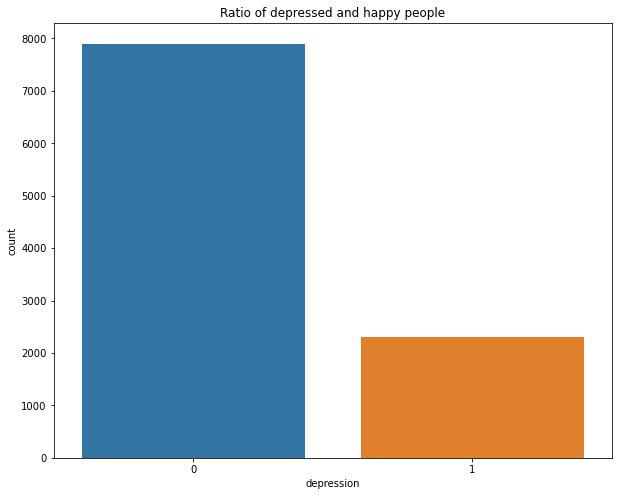

In [149]:
#plotting the labels
plt.figure(figsize = (10, 8))
sns.countplot(df["depression"])
plt.title("Ratio of depressed and happy people")

In [150]:
###ratio of depressed people
dep_prop = np.round(((len(df[df["depression"] == 1])/ len(df)) * 100), 2)
print(f"Percentage of depressed people: {dep_prop}%")

Percentage of depressed people: 22.63%


It is not obvious whether 1/4 can be considered as imbalanced data. Hence, we will try both variants: the data as it is and the data after oversampling is used.

## Splitting the data into train and test sets

In [151]:
from sklearn.model_selection import train_test_split

In [152]:
#dependent and independent variables 
X = df["text"]
y = df["depression"]

In [153]:
#reshuffling the data
from sklearn.utils import shuffle
X, y = shuffle(X, y)

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [155]:
#checking the new shapes
print(X_train.shape, X_test.shape)

(8169,) (2043,)


## Vectorizing the data

The next step is to convert the words into vectors. For this, we will use to approaches: CountVectorizer and TfIdfVectorizer.The first is simply counting the words and the second one is computing the frequency of the word in the document and in the whole text.

In [156]:
#Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(lowercase = True, stop_words = 'english')

In [157]:
#transforming train and test sets
X_train_count = count_vect.fit_transform(X_train)
X_test_count = count_vect.transform(X_test)

In [158]:
#checking the new shapes
print(X_train_count.shape, X_test_count.shape)

(8169, 13113) (2043, 13113)


In [159]:
#TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vect = TfidfVectorizer(lowercase = True, stop_words = 'english')

In [160]:
#transforming train and test sets
X_train_tf = tf_vect.fit_transform(X_train)
X_test_tf = tf_vect.transform(X_test)

In [161]:
#checking the new shapes
print(X_train_tf.shape, X_test_tf.shape)

(8169, 13113) (2043, 13113)


### Oversampling

In [162]:
# oversampling the data
import imblearn
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state= 0, sampling_strategy = 0.8)
X_train_over_count, y_train_over_count = over_sampler.fit_sample(X_train_count, y_train)

In [163]:
#values after resampling
print(y_train_over_count.value_counts())

0    6320
1    5056
Name: depression, dtype: int64


In [164]:
#the same for tf-idf data
X_train_over_tf, y_train_over_tf = over_sampler.fit_sample(X_train_tf, y_train)
#values after resampling
print(y_train_over_tf.value_counts())

0    6320
1    5056
Name: depression, dtype: int64


## Building the model

Now the data is ready to be used as an input for ML models.

In [165]:
#importing metrics
from sklearn.metrics import accuracy_score, classification_report

In [166]:
#Support Vector Machine
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train_count, y_train)
print(classification_report(svm.predict(X_test_count), y_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1609
           1       0.94      1.00      0.96       434

    accuracy                           0.98      2043
   macro avg       0.97      0.99      0.98      2043
weighted avg       0.99      0.98      0.98      2043



In [167]:
#Support Vector Machine
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train_tf, y_train)
print(classification_report(svm.predict(X_test_tf), y_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1607
           1       0.94      1.00      0.97       436

    accuracy                           0.99      2043
   macro avg       0.97      0.99      0.98      2043
weighted avg       0.99      0.99      0.99      2043



Well, the point is that the data occured to be pretty easy for the Machine Learning Algorithms which can definitely state whether twitter user has depression or not. Of cource, no oversampling is required in this case.

In [176]:
#defining the function for single prediction
def depression_detection(tweet):
    #transforming the data
    tweet_vect = tf_vect.transform([tweet])
    #predicting
    pred = svm.predict(tweet_vect)
    if pred == 0:
        print("No depression!")
    else:
        print("You'd rather visit the doctor!")

In [177]:
#examples
depression_detection("i have depression")

You'd rather visit the doctor!


In [178]:
depression_detection("Have a nice day!")

No depression!


# Conclusion

We have analyzed the dataset with tweets and detected whether people are having depression or not. Occasionally, SVM model gave 99% accuracy without even being somewhat tuned. However, even for more complex datasets the algorithm of actions will be the same. Hence, the goal can be marked as achieved. 